In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

# Load the datasets
contract = pd.read_csv('/datasets/contract.csv')
internet = pd.read_csv('/datasets/internet.csv')
phone = pd.read_csv('/datasets/phone.csv')
personal = pd.read_csv('/datasets/personal.csv')

# Rename user_id to customerID in the internet dataset
internet.rename(columns={'user_id': 'customerID'}, inplace=True)

# Convert customerID columns to string type across all datasets
contract['customerID'] = contract['customerID'].astype(str)
internet['customerID'] = internet['customerID'].astype(str)
phone['customerID'] = phone['customerID'].astype(str)
personal['customerID'] = personal['customerID'].astype(str)

# Handle missing EndDate as No Churn
contract['EndDate'] = contract['EndDate'].replace('No', pd.NaT)
contract['Churn'] = contract['EndDate'].isna().astype(int)

# Convert EndDate to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

# Create ContractLength feature
contract['ContractLength'] = ((contract['EndDate'].fillna(pd.Timestamp('2020-02-01')) - contract['BeginDate']).dt.days / 30).astype(int)

# Merge the datasets using outer join
data_merged = contract.merge(personal, on='customerID', how='outer').merge(internet, on='customerID', how='outer').merge(phone, on='customerID', how='outer')

# Handle missing values for categorical variables
data_merged['MultipleLines'].fillna('No service', inplace=True)
data_merged['mb_used'].fillna(0, inplace=True)

# Convert TotalCharges to numeric and handle errors
data_merged['TotalCharges'] = pd.to_numeric(data_merged['TotalCharges'], errors='coerce').fillna(0)

# One-Hot Encoding for categorical variables
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'MultipleLines']
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_array = encoder.fit_transform(data_merged[categorical_features])

# Manually create column names
encoded_features = pd.DataFrame(encoded_array, columns=encoder.get_feature_names(categorical_features))

# Combine the encoded features with the dataset
data_merged = data_merged.drop(categorical_features, axis=1)
data_merged = pd.concat([data_merged, encoded_features], axis=1)

# Ensure all features are numeric and handle NaN values
for col in data_merged.columns:
    if data_merged[col].dtype == 'object':
        data_merged[col] = pd.to_numeric(data_merged[col], errors='coerce').fillna(0)

# Replace any remaining NaN or infinite values with 0
data_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
data_merged.fillna(0, inplace=True)

# Drop columns not needed for the model
data_merged.drop(['customerID', 'BeginDate', 'EndDate', 'Unnamed: 0', 'id', 'session_date'], axis=1, inplace=True)

# Split the data into training and testing sets
X = data_merged.drop('Churn', axis=1)
y = data_merged['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Implement Logistic Regression with class weighting
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
auc_roc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)

print(f"AUC-ROC: {auc_roc}")
print(f"Accuracy: {accuracy}")







AUC-ROC: 0.9980492792675535
Accuracy: 0.9884620301713117


In [13]:
# Get the feature names (after one-hot encoding)
feature_names = X.columns

# Get the coefficients from the model
coefficients = model.coef_[0]

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calculate the absolute value of the coefficients to sort by importance
feature_importance['Importance'] = feature_importance['Coefficient'].apply(lambda x: np.abs(x))

# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
top_features = feature_importance.head(10)
print(top_features)


                                  Feature  Coefficient  Importance
15                             gender_nan    -1.781515    1.781515
7                                Type_nan    -1.781515    1.781515
9                    PaperlessBilling_nan    -1.781515    1.781515
19                         Dependents_nan    -1.781515    1.781515
13                      PaymentMethod_nan    -1.781515    1.781515
17                            Partner_nan    -1.781515    1.781515
10  PaymentMethod_Credit card (automatic)     1.262867    1.262867
6                           Type_Two year     1.243975    1.243975
4                                 mb_used    -1.221023    1.221023
12             PaymentMethod_Mailed check     1.084969    1.084969


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Step 1: Try a more complex model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Step 2: Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 3: Evaluate the best model found
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Step 4: Model Evaluation
auc_roc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best AUC-ROC: {auc_roc}")
print(f"Best Accuracy: {accuracy}")


Best AUC-ROC: 0.9978828719945472
Best Accuracy: 0.9897085144464332


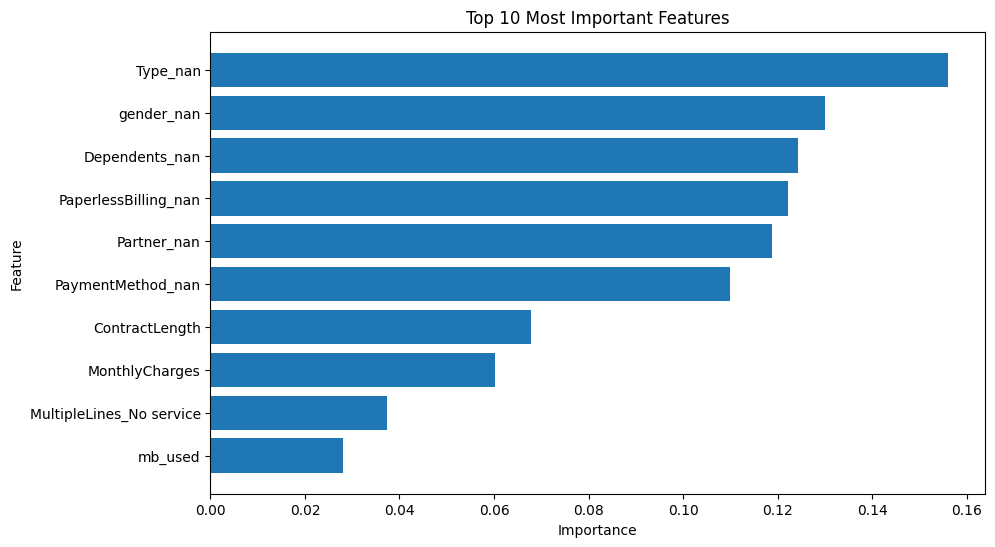

In [15]:
import matplotlib.pyplot as plt


# Get feature importances
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
top_features = feature_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.show()


AUC-ROC for Logistic Regression: 0.9980492792675535
Accuracy for Logistic Regression: 0.9884620301713117
